<a href="https://colab.research.google.com/github/alonsosilvaallende/Survival_Analysis/blob/master/Random_Survival_Forest_vs_Gradient_Boosting_Cox_PH_a_practical_guide-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival Analysis: Cox PH vs Random Survival Forest vs Gradient Boosting Cox PH: a practical guide

[Alonso Silva](http://www.dim.uchile.cl/~alsilva/) [(@alonsosilva)](https://twitter.com/alonsosilva) | 2019/09/22



The objective of this notebook is to compare three methods (Cox proportional hazards, Random survival forest, and Gradient boosting Cox PH) to estimate the survival probability given a set of features/covariables.

To perform this analysis we will use [scikit-learn](https://scikit-learn.org/), [scikit-survival](https://pypi.org/project/scikit-survival/), [pysurvival](https://pysurvival.io), and [lifelines](https://lifelines.readthedocs.io/en/latest/).

In [0]:
# install scikit-survival, pysurvival, and lifelines
!pip install -q scikit-survival lifelines pysurvival

In [0]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## An example: German Breast Cancer Study Group 2 (gbcsg)

This dataset contains the following 8 features/covariables:

- age: age (in years), 
- estrec: estrogen receptor (in fmol), 
- hotTh: hormonal therapy (yes or no), 
- menostat: menopausal status (premenopausal or postmenopausal),
- pnodes: number of positive nodes, 
- progrec: progesterone receptor (in fmol), 
- tgrade: tumor grade (I < II < III), 
- tsize: tumor size (in mm).

and the two outputs: 

- recurrence free time (in days),
- censoring indicator (0 - censored, 1 - event).

The dataset has 686 samples and 8 features/covariables.


**References**

M. Schumacher, G. Basert, H. Bojar, K. Huebner, M. Olschewski, W. Sauerbrei, C. Schmoor, C. Beyerle, R.L.A. Neumann and H.F. Rauschecker for the German Breast Cancer Study Group (1994), [Randomized 2 x 2 trial evaluating hormonal treatment and the duration of chemotherapy in node-positive breast cancer patients](https://www.ncbi.nlm.nih.gov/pubmed/7931478). Journal of Clinical Oncology, 12, 2086–2093.


In [0]:
# download the dataset
from sksurv.datasets import load_gbsg2

X, y = load_gbsg2()

In [4]:
# number of samples, number of features/covariables
print(f'Number of samples: {X.shape[0]}')
print(f'Number of features/covariables: {X.shape[1]}')

Number of samples: 686
Number of features/covariables: 8


In [5]:
# show the first 5 rows
X.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


In [0]:
# function to transform y (a numpy nd array) to a dataframe
def target2df(y):
  event = [y[i][0] for i in range(len(y))]
  time = [y[i][1] for i in range(len(y))]
  df_y = pd.DataFrame(data={'time': time, 'event': event})
  return df_y

In [7]:
# show the first 10 rows
df_y = target2df(y)
df_y.head(10)

,time,event
0,1814.0,True
1,2018.0,True
2,712.0,True
3,1807.0,True
4,772.0,True
5,448.0,True
6,2172.0,False
7,2161.0,False
8,471.0,True
9,2014.0,False


One of the main challenges of survival analysis is **right censoring**, i.e., by the end of the study, the event of interest (for example, in medicine 'death of a patient' or in this dataset 'recurrence of cancer') has only occurred for a subset of the observations.

The right censoring in this dataset is given by the column name 'event' and it's a variable which can take value 'True' if the patient had a recurrence of cancer or 'False' if the patient is recurrence free.

In [8]:
print(f'Number of samples: {len(df_y)}')
print(f'Number of right censored samples: {len(df_y.query("event == False"))}')
print(f'Percentage of right censored samples: {100*len(df_y.query("event == False"))/len(df_y):.1f}%')

Number of samples: 686
Number of right censored samples: 387
Percentage of right censored samples: 56.4%


There are 387 patients (56.4%) who were right censored (recurrence free) at the end of the study.

## Preprocessing

In [9]:
# count how many NaN values does each feature/covariable have
X.isnull().sum()

age         0
estrec      0
horTh       0
menostat    0
pnodes      0
progrec     0
tgrade      0
tsize       0
dtype: int64

There are no NaN values.

In [10]:
# show datatypes of features/covariables
X.dtypes

age          float64
estrec       float64
horTh       category
menostat    category
pnodes       float64
progrec      float64
tgrade      category
tsize        float64
dtype: object

We need to transform the categorical variables to numerical variables.

In [11]:
# tgrade: tumor grade is an ordered categorical variable so we treat it differently
X['tgrade'] = X['tgrade'].cat.as_ordered()
X['tgrade'].dtype

CategoricalDtype(categories=['I', 'II', 'III'], ordered=True)

In [12]:
# menostat: menopausal status (premenopausal or postmenopausal) doesn't need to be ordered since it only has two categories
X['menostat'].dtype

CategoricalDtype(categories=['Pre', 'Post'], ordered=False)

In [13]:
# horTh: hormonal therapy (yes or no) doesn't need to be ordered since it only has two categories
X['horTh'].dtype

CategoricalDtype(categories=['no', 'yes'], ordered=False)

In [0]:
# we transform the categorical variables to numerical variables
X['horTh'] = X['horTh'].cat.codes
X['menostat'] = X['menostat'].cat.codes
X['tgrade'] = X['tgrade'].cat.codes

The categorical variables became numerical:

In [15]:
X.dtypes

age         float64
estrec      float64
horTh          int8
menostat       int8
pnodes      float64
progrec     float64
tgrade         int8
tsize       float64
dtype: object

We split the dataset into training (80%) and validation (20%) datasets.

In [0]:
from sklearn.model_selection import train_test_split

X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=311)

In [17]:
print(f'Number of training samples: {len(y_trn)}')
print(f'Number of validation samples: {len(y_val)}')

Number of training samples: 548
Number of validation samples: 138


If we didn't have the features, we could obtain an estimated [survival function](https://en.wikipedia.org/wiki/Survival_function) (complementary cumulative distribution function) and an estimated median time to event (recurrence) from the training dataset for the validation dataset. We use the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) to estimate the survival function and median time to event of a patient recurrence.

In [0]:
df_y_trn = target2df(y_trn)
T_trn = df_y_trn[['time']]
E_trn = df_y_trn[['event']]

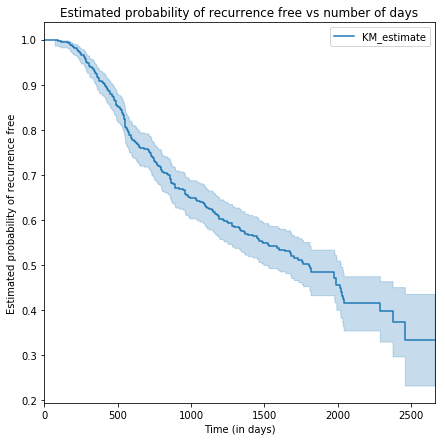

In [19]:
# Kaplan-Meier estimator
from lifelines import KaplanMeierFitter

kmf_trn = KaplanMeierFitter()
kmf_trn.fit(T_trn, E_trn)

plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf_trn.plot(ax=ax)
plt.title('Estimated probability of recurrence free vs number of days')
plt.xlabel('Time (in days)')
plt.ylabel('Estimated probability of recurrence free')
plt.show()

In [20]:
print(f'Estimated median time to event (in days): {kmf_trn.median_}')

Estimated median time to event (in days): 1806.0


The estimated median time to event is 1806 days or 4.95 years.

Let's see how good is our estimated survival function and estimated median time to event in the training dataset.

In [0]:
df_y_val = target2df(y_val)
T_val = df_y_val[['time']]
E_val = df_y_val[['event']]

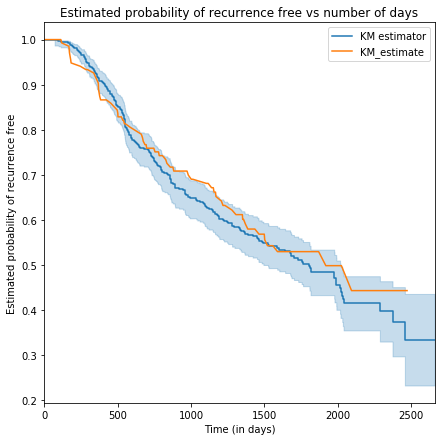

In [22]:
# Kaplan-Meier estimators
kmf_val = KaplanMeierFitter()
kmf_val.fit(T_val, E_val)

plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf_trn.plot(ax=ax, label="KM estimator")
kmf_val.survival_function_.plot(ax=ax, label="KM")
plt.title('Estimated probability of recurrence free vs number of days')
plt.xlabel('Time (in days)')
plt.ylabel('Estimated probability of recurrence free')
plt.legend()
plt.show()

In [23]:
print(f'Median time to event training (in days): {kmf_trn.median_}')
print(f'Median time to event validation (in days): {kmf_val.median_}')

Median time to event training (in days): 1806.0
Median time to event validation (in days): 1918.0


The survival function of the validation dataset is not far from the estimated survival function. The median time to event in the validation dataset is 1918 days or 5,25 years.

## Cox proportional hazards

The first model we will use to make our risk predictions is [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model). To measure the performance of our models we use [Harrell's concordance index or c-index](https://www.semanticscholar.org/paper/Multivariable-prognostic-models%3A-issues-in-models%2C-Harrell-Lee/7705392f1068c76669de750c6d0da8144da3304d):
+ a value of 0.5 denotes a random model,
+ a value of 1.0 denotes a perfect model,
+ a value of 0.0 denotes a perfectly wrong model.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

steps = [('scaler', StandardScaler()), ('coxph', CoxPHSurvivalAnalysis())]
cox = Pipeline(steps)
cox.fit(X_trn, y_trn)
ci_cox_trn = concordance_index_censored(y_trn["cens"], y_trn["time"], cox.predict(X_trn))[0]
ci_cox_val = concordance_index_censored(y_val["cens"], y_val["time"], cox.predict(X_val))[0]
print(f'c-index of Cox: train: {ci_cox_trn:.3f}, valid: {ci_cox_val:.3f}')

c-index of Cox: train: 0.698, valid: 0.631


Our model learnt something since the value is much higher than 0.5. However, it's far from perfect.

The result of our model is a vector of coefficients, one for each feature/covariable, where each value corresponds to the [log hazard ratio](https://en.wikipedia.org/wiki/Hazard_ratio).

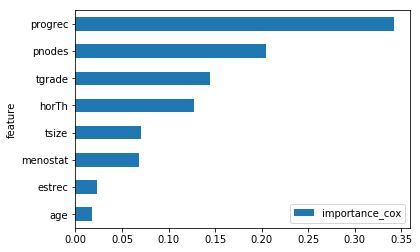

In [25]:
# feature importance
fi_cox = cox.named_steps['coxph'].coef_
rfi_cox = np.abs(fi_cox)/np.sum(np.abs(fi_cox))
lab = X_trn.columns
df_fi_cox = pd.DataFrame({'feature': lab, 'importance_cox': rfi_cox}).set_index('feature')
df_fi_cox = df_fi_cox.sort_values(by='importance_cox', ascending=True)
df_fi_cox.plot.barh(y='importance_cox');

In [26]:
df_fi_cox.sort_values(by='importance_cox', ascending=False)

,importance_cox
feature,
progrec,0.342336
pnodes,0.204661
tgrade,0.144798
horTh,0.127798
tsize,0.070563
menostat,0.068444
estrec,0.023252
age,0.018147


The progesterone receptor (progrec) seems to be the most important feature according to Cox proportional hazards model, then the quantity of nodes (pnodes) and tumor grade (tgrade).

## Random Survival Forest

The second model we will use to make our risk predictions is [Random survival forest](https://square.github.io/pysurvival/models/random_survival_forest.html). Random survival forest is an extension of the Random forest model, introduced by [Breiman et al in 2001](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf), that can take into account right censoring. The Random survival forest was developped by [Ishwaran et al. in 2008](https://arxiv.org/pdf/0811.1645.pdf).

In [27]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index

rsf = RandomSurvivalForestModel(num_trees=200)
rsf.fit(X_trn, df_y_trn["time"], df_y_trn["event"])
ci_rsf_trn = concordance_index(rsf, X_trn, df_y_trn["time"], df_y_trn["event"])
ci_rsf_val = concordance_index(rsf, X_val, df_y_val["time"], df_y_val["event"])
print(f'c-index of Random survival forest: train: {ci_rsf_trn:.3f}, valid: {ci_rsf_val:.3f}')

c-index of Random survival forest: train: 0.760, valid: 0.672


The c-index is higher to the one obtained by Cox proportional hazards model.

We do a horizontal bar plot of the most important features/covariables.

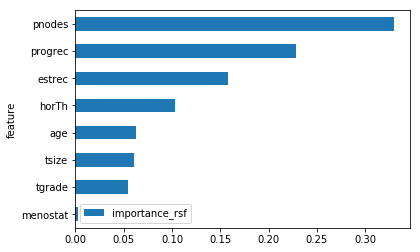

In [28]:
# feature importance
fi_rsf = rsf.variable_importance_
rfi_rsf =  np.abs(fi_rsf)/np.sum(np.abs(fi_rsf))
lab = X_trn.columns
df_fi_rsf = pd.DataFrame({'feature': lab, 'importance_rsf': rfi_rsf}).set_index('feature')
df_fi_rsf = df_fi_rsf.sort_values(by='importance_rsf', ascending=True)
df_fi_rsf.plot.barh(y='importance_rsf');

In [29]:
df_fi_rsf.sort_values(by='importance_rsf', ascending=False)

,importance_rsf
feature,
pnodes,0.330066
progrec,0.228782
estrec,0.157901
horTh,0.103432
age,0.063189
tsize,0.060331
tgrade,0.053985
menostat,0.002315


The number of nodes (pnodes), the progesterone receptor (progrec), and the estrogen receptor (estrec) seem to be the most importan features for the Random survival forest model.

## Gradient boosting Cox PH

The third model we will use to make our risk predictions is [Gradient boosting Cox PH](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.ensemble.GradientBoostingSurvivalAnalysis.html).

In [30]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gb = GradientBoostingSurvivalAnalysis(random_state=42)
gb.fit(X_trn, y_trn)
ci_gb_trn = concordance_index_censored(y_trn["cens"], y_trn["time"], gb.predict(X_trn))[0]
ci_gb_val = concordance_index_censored(y_val["cens"], y_val["time"], gb.predict(X_val))[0]
print(f'c-index of Gradient Boosting Cox PH: train: {ci_gb_trn:.3f}, valid: {ci_gb_val:.3f}')

c-index of Gradient Boosting Cox PH: train: 0.797, valid: 0.708


The c-index is higher to the one obtained by Cox proportional hazards model and to the one obtained by Random survival forest model.

We do a horizontal bar plot of the most important features/covariables.

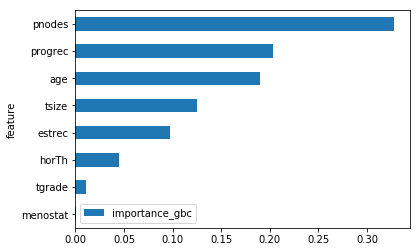

In [31]:
# feature importance
fi_gb = gb.feature_importances_
rfi_gb =  np.abs(fi_gb)/np.sum(np.abs(fi_gb))
lab = X_trn.columns
df_fi_gb = pd.DataFrame({'feature': lab, 'importance_gbc': rfi_gb}).set_index('feature')
df_fi_gb = df_fi_gb.sort_values(by='importance_gbc', ascending=True)
df_fi_gb.plot.barh(y='importance_gbc');

In [32]:
df_fi_gb.sort_values(by='importance_gbc', ascending=False)

,importance_gbc
feature,
pnodes,0.328025
progrec,0.203267
age,0.189884
tsize,0.125400
estrec,0.097504
horTh,0.044402
tgrade,0.011178
menostat,0.000341


The number of nodes (pnodes), the progesterone receptor (progrec), and age seem to be the most importan features for the Gradient boosting Cox PH model.

It may be the case that it was just luck on the split of our dataset which produced the advantage of Gradient boosting Cox PH compared to Random survival forest and Cox proportional hazards.

Let's now compare these approaches with several different splits of the training and validation datasets.

In [0]:
# choose 20 random seeds
np.random.seed(0)
seeds = np.random.permutation(1000)[:20]

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

cox_scores = []
gb_scores = []
rsf_scores = []
for _seed in seeds:
  X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=_seed)
  
  cox = make_pipeline(StandardScaler(), CoxPHSurvivalAnalysis())
  cox.fit(X_trn, y_trn)
  cox_scores.append(cox.score(X_val, y_val))
  
  gb = GradientBoostingSurvivalAnalysis(random_state=_seed)
  gb.fit(X_trn, y_trn)
  gb_scores.append(gb.score(X_val, y_val))  

  rsf = RandomSurvivalForestModel(num_trees=200)
  df_y_trn = target2df(y_trn)
  df_y_val = target2df(y_val)
  rsf.fit(X_trn, df_y_trn["time"], df_y_trn["event"], seed=_seed)
  rsf_scores.append(concordance_index(rsf, X_val, df_y_val["time"], df_y_val["event"]))

In [35]:
print(f'Cox proportional hazards model: Mean c-index: {np.mean(cox_scores):.3f}, standard deviation: {np.std(cox_scores):.3f}')
print(f'Random Survival Forest model: Mean c-index: {np.mean(rsf_scores):.3f}, standard deviation: {np.std(rsf_scores):.3f}')
print(f'Gradient boosting Cox PH model: Mean c-index: {np.mean(gb_scores):.3f}, standard deviation: {np.std(gb_scores):.3f}')

Cox proportional hazards model: Mean c-index: 0.664, standard deviation: 0.035
Random Survival Forest model: Mean c-index: 0.676, standard deviation: 0.036
Gradient boosting Cox PH model: Mean c-index: 0.689, standard deviation: 0.029


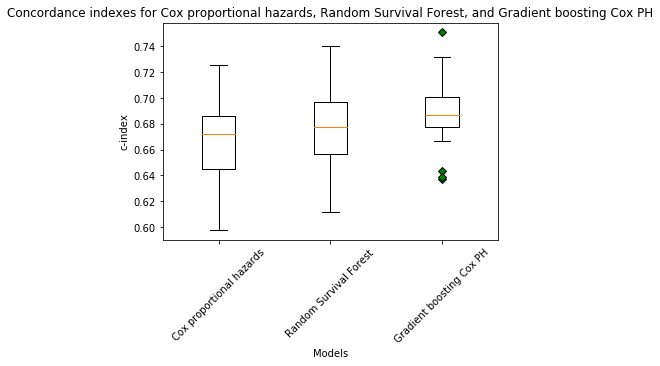

In [36]:
data = [cox_scores, rsf_scores, gb_scores]
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Concordance indexes for Cox proportional hazards, Random Survival Forest, and Gradient boosting Cox PH')
ax1.boxplot(data, notch=False, flierprops=green_diamond)
ax1.set_xticklabels(['Cox proportional hazards', 'Random Survival Forest', 'Gradient boosting Cox PH'], rotation=45)
ax1.set_xlabel('Models')
ax1.set_ylabel('c-index')
plt.show()

We look at the difference between the c-indexes of Gradient Boosting Cox PH and Cox proportional hazards.

In [0]:
data1 = [gb_scores[i] - cox_scores[i] for i in range(len(gb_scores))]
data2 = [gb_scores[i] - rsf_scores[i] for i in range(len(gb_scores))]

In [0]:
data = [data1, data2]

In [39]:
print(f'Difference c-indexes of Gradient boosting Cox PH minus Cox proportional hazards: mean :{np.mean(data1):.3f}, standard deviation: {np.std(data1):.3f}')

Difference c-indexes of Gradient boosting Cox PH minus Cox proportional hazards: mean :0.025, standard deviation: 0.028


In [40]:
print(f'Difference c-indexes of Gradient boosting Cox PH minus Random survival forest: mean :{np.mean(data2):.3f}, standard deviation: {np.std(data2):.3f}')

Difference c-indexes of Gradient boosting Cox PH minus Random survival forest: mean :0.013, standard deviation: 0.031


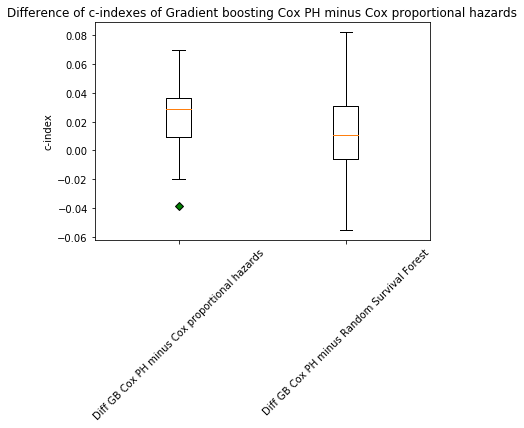

In [41]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Difference of c-indexes of Gradient boosting Cox PH minus Cox proportional hazards')
ax1.boxplot(data, notch=False, flierprops=green_diamond)
ax1.set_xticklabels(['Diff GB Cox PH minus Cox proportional hazards', 'Diff GB Cox PH minus Random Survival Forest'], rotation=45)
ax1.set_xlabel('')
ax1.set_ylabel('c-index')
plt.show()

In [42]:
print(f'Percentage of times Gradient boosting Cox PH beats Cox proportional hazards: {100*sum(x > 0 for x in data1)/len(data1):.0f}%')

Percentage of times Gradient boosting Cox PH beats Cox proportional hazards: 80%


In [43]:
print(f'Percentage of times Gradient boosting Cox PH beats Random survival forest: {100*sum(x > 0 for x in data2)/len(data2):.0f}%')

Percentage of times Gradient boosting Cox PH beats Random survival forest: 60%


In most of the cases (80%), Gradient boosting Cox PH model performs better than Cox proportional hazards model in this dataset. In most of the cases (60%), Gradient boosting Cox PH performs better than Random survival forest, however this percentage is smaller.